# GRAD-E1326: Python Programming for Data Scientists
## Ph.D. Hannah Béchara
### Ji Yoon Han & Mariana G. Carrillo 

**Initial Project report: Tweet Sentiment Analysis**


In [2]:
#Importing libraries for sentiment analysis 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk #Natural Language Processing Package 
import os #functions for interacting with the operating system
import spacy #Models for NLP
import torch #also for NLP
from tqdm.notebook import tqdm 
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
import transformers #contains pretrained models to perform tasks on texts
from transformers import BertForSequenceClassification
from wordcloud import WordCloud #For nice wordclouds
import tensorflow as tf #Package to develop train models 
from tensorflow.keras.preprocessing import text 
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
import time #for handling dates and times
import re 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix, classification_report
from nltk.tokenize import TweetTokenizer


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Loading data

In [3]:
#Loading and cleaning data
train_data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin-1')

**Data cleaning**

In [ ]:
#Clean Tweets --> TRAIN DATA (these functions run locally, not on jupiter notebooks)

!pip install tweet-preprocessor #processing library 
import preprocessor as p 

def preprocess_tweet(row):
    text = row['OriginalTweet']
    text = p.clean(text)
    return text

train_data['OriginalTweet'] = train_data.apply(preprocess_tweet, axis=1) #remove urls, hashtags, mentions, etc.

train_data.count() #check tweets

train_data = train_data.dropna() #drop NAs
train_data = train_data.drop_duplicates() #drop duplicates

train_data.count() #check tweets again

from gensim.parsing.preprocessing import remove_stopwords #removing stopwords

def stopword_removal(row):
    text = row['OriginalTweet']
    text = remove_stopwords(text)
    return text

test_data['OriginalTweet'] = test_data.apply(stopword_removal, axis=1)

test_data['OriginalTweet'] = test_data['OriginalTweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ') #make lowercase, remove punctuation

test_data.head() #check it worked

In [ ]:
#Clean Tweets --> TEST DATA

def preprocess_tweet(row):
    text = row['OriginalTweet']
    text = p.clean(text)
    return text

    test_data['OriginalTweet'] = test_data.apply(preprocess_tweet, axis=1) #remove urls, hashtags, mentions, etc.

    test_data.count() #check tweets

    test_data = test_data.dropna() #drop NAs
    test_data = test_data.drop_duplicates() #drop duplicates

    test_data.count() #check tweets again

from gensim.parsing.preprocessing import remove_stopwords #removing stopwords

def stopword_removal(row):
    text = row['OriginalTweet']
        text = remove_stopwords(text)
        return text

    test_data['OriginalTweet'] = test_data.apply(stopword_removal, axis=1)

    test_data['OriginalTweet'] = test_data['OriginalTweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ') #make lowercase, remove punctuation

    test_data.head()

Data preview

In [4]:
#Train data 

train_data.head(5) #preview
train_data.describe() #descriptive statistics


,UserName,ScreenName
count,41157.000000,41157.000000
mean,24377.000000,69329.000000
std,11881.146851,11881.146851
min,3799.000000,48751.000000
25%,14088.000000,59040.000000
50%,24377.000000,69329.000000
75%,34666.000000,79618.000000
max,44955.000000,89907.000000


In [5]:
#Test data

test_data.head(5) #preview
test_data.describe() #descriptive statistics


,UserName,ScreenName
count,3798.000000,3798.000000
mean,1899.500000,46851.500000
std,1096.532489,1096.532489
min,1.000000,44953.000000
25%,950.250000,45902.250000
50%,1899.500000,46851.500000
75%,2848.750000,47800.750000
max,3798.000000,48750.000000


### Exploratory Data analysis

#### Test data

Text(0.5, 0.98, 'Histogram of tweet distribution per sentiment classification (Test data)')

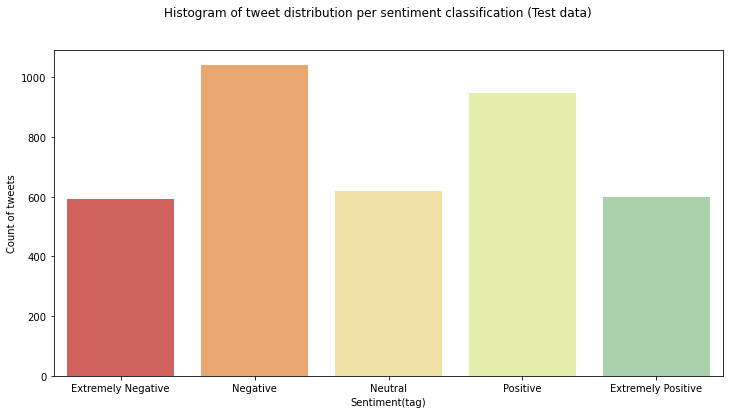

In [6]:
#Create histogram --> Distribution TEST DATA
#Can we also make this a function?
plt.figure(figsize=(12,6)) #specifying the size of the figure
sns.set_palette("Spectral") #color palette
sns.countplot(x='Sentiment', data=test_data, order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], )
plt.xlabel('Sentiment(tag)')
plt.ylabel('Count of tweets')
plt.suptitle('Histogram of tweet distribution per sentiment classification (Test data)')


Text(0, 0.5, 'Tweet Count')

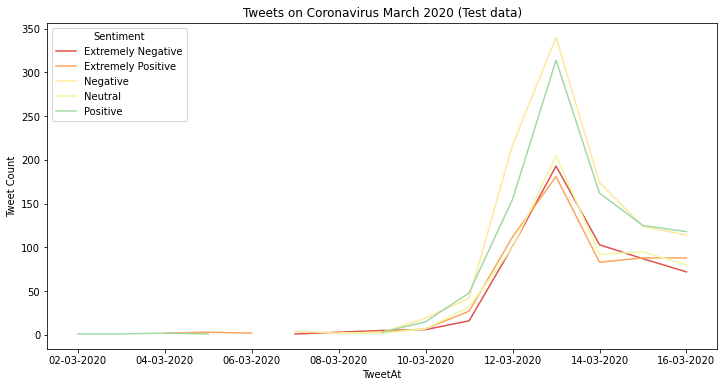

In [8]:
#Distribution of tweet counts 
test_data.groupby(['TweetAt', 'Sentiment'])['OriginalTweet'].count().unstack().plot(kind='line', figsize=(12, 6))
plt.title('Tweets on Coronavirus March 2020 (Test data)')
plt.ylabel('Tweet Count')

In [ ]:
#Histogram of Top 10 Hashtags --> TEST DATA

hashtags = test_data['OriginalTweet'].apply(lambda x: pd.value_counts(re.findall('(#\w+)', x.lower() )))\
                     .sum(axis=0)\
                     .to_frame().reset_index()\
                     .sort_values(by=0,ascending=False)
hashtags.columns = ['hashtag','occurences']

hashtags[:10].plot(kind='bar',y='occurences',x='hashtag')
plt.tight_layout()
plt.grid(False)
plt.suptitle('Top 10 Hashtags for keyword: Covid (Test Data)', fontsize=14)

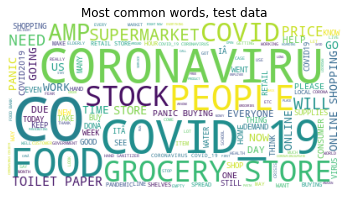

In [11]:
#Attempt to create wordcloud - test data
def wordcloud2(test_data):
    stopwords = set(STOPWORDS)
    stopwords.add("https")
    stopwords.add("00A0")
    stopwords.add("00BD")
    stopwords.add("00B8")
    stopwords.add("ed")
    wordcloud2 = WordCloud(background_color="white",stopwords=stopwords).generate(" ".join([i for i in test_data['OriginalTweet'].str.upper()]))
    plt.imshow(wordcloud2)
    plt.axis("off")
    plt.title("Most common words, test data")
    figsize=(12, 6)

wordcloud2(test_data)  

#### Train data

Text(0.5, 0.98, 'Histogram of tweet distribution per sentiment classification (Train data)')

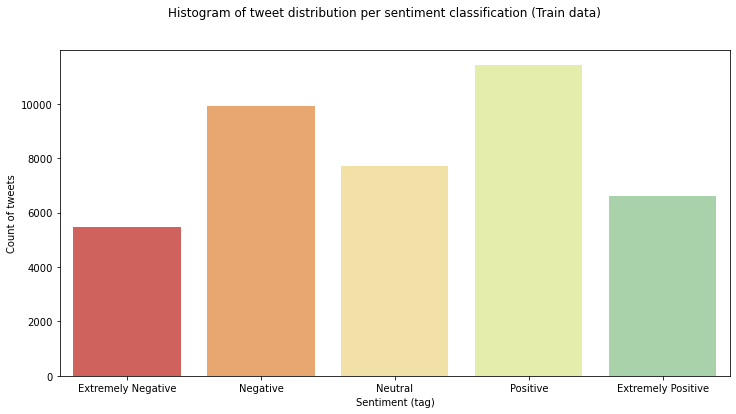

In [7]:
#Create histogram --> Distribution TRAIN DATA
plt.figure(figsize=(12,6))
sns.set_palette("Spectral")
sns.countplot(x='Sentiment', data=train_data, order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], )
plt.xlabel('Sentiment (tag)')
plt.ylabel('Count of tweets')
plt.suptitle('Histogram of tweet distribution per sentiment classification (Train data)')

Text(0, 0.5, 'Tweet Count')

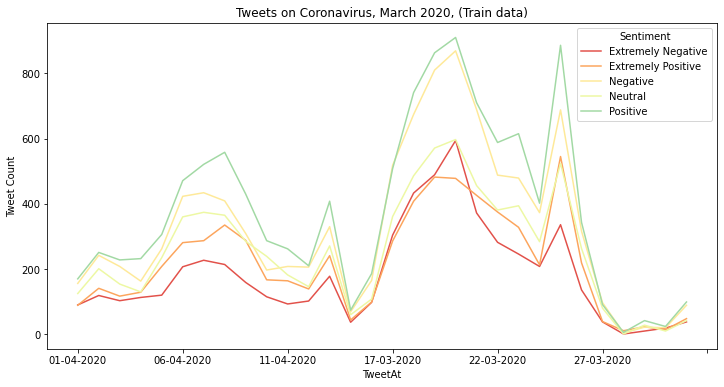

In [9]:
#Distribution of tweet counts 
train_data.groupby(['TweetAt', 'Sentiment'])['OriginalTweet'].count().unstack().plot(kind='line', figsize=(12, 6))
plt.title('Tweets on Coronavirus, March 2020, (Train data)')
plt.ylabel('Tweet Count')

In [ ]:
#Histogram of Top 10 Hashtags --> TRAIN DATA

hashtags = train_data['OriginalTweet'].apply(lambda x: pd.value_counts(re.findall('(#\w+)', x.lower() )))\
                     .sum(axis=0)\
                     .to_frame().reset_index()\
                     .sort_values(by=0,ascending=False)
hashtags.columns = ['hashtag','occurences']

hashtags[:10].plot(kind='bar',y='occurences',x='hashtag')
plt.tight_layout()
plt.grid(False)
plt.suptitle('Top 10 Hashtags for keyword: Covid (Train Data)', fontsize=14)

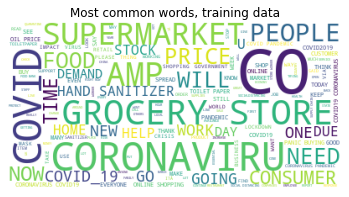

In [10]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#Attempt to create wordcloud
def wordcloud1(training_data):
    stopwords = set(STOPWORDS)
    stopwords.add("https")
    stopwords.add("00A0")
    stopwords.add("00BD")
    stopwords.add("00B8")
    stopwords.add("ed")
    wordcloud1 = WordCloud(background_color="white",stopwords=stopwords).generate(" ".join([i for i in train_data['OriginalTweet'].str.upper()]))
    plt.imshow(wordcloud1)
    plt.axis("off")
    plt.title("Most common words, training data")
    figsize=(12, 6)

wordcloud1(train_data)  

In [ ]:
#This was the first attempt to clean the tweets, 
#but the function cannot be applied to the dataset, rather to a vector

#First create vector to apply tidy tweets formula 
untidyTweets_train = train_data['OriginalTweet'].copy()
sentiment_tag_train = train_data['Sentiment'].copy()

#create a function that allows to process the tweets by:

def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', ' ', tweet) #removing urls
    tweet = re.sub(r'<.*?>', ' ', tweet)  # removing html tags    
    tweet = re.sub(r'\d+', ' ', tweet) #removing digits
    tweet = re.sub(r'#\w+', ' ', tweet)    #removing hashtags
    tweet = re.sub(r'@\w+', ' ', tweet) #removing mentions
    tweet = tweet.split() #removing stop words
    tweet = " ".join([word for word in tweet if not word in stop_words])
    return tweet

stop_words = stopwords.words('english') #defining var to remove stopwords in the process_tweet function 

tidyTweets_train = untidyTweets_train.apply(clean_tweet)
tidyTweets_train.head()

In [ ]:
#First create vector to apply tidy tweets formula - test
untidyTweets_test = test_data['OriginalTweet'].copy()
sentiment_tag_test = test_data['Sentiment'].copy()

tidyTweets_test = untidyTweets_test.apply(clean_tweet)
tidyTweets_test.head()

### Tokenization

In [ ]:
#Using tweet tokenizer
#Evaluate different tokenizers



#How can we write a function to tokenize all tweets? 

def tweet_Tokenizer()


### References 
* Matplotlib.org. 2020. Pyplot Tutorial — Matplotlib 3.3.2 Documentation. [online] Available at: <https://matplotlib.org/tutorials/introductory/pyplot.html> [Accessed 20 October 2020].
* Kaggle.com. 2020. Sentiment Prediction. [online] Available at: <https://www.kaggle.com/shahraizanwar/covid19-tweets-sentiment-prediction-rnn-85-acc> [Accessed 18 October 2020].
* 